# Hyperparameter tuning

This notebook contains our experiments to determine the best model / parameters to tackle the **Medical imaging segmentation** task

The pipeline closely mirrors the structure of the *UNET_Image_Segmentation.ipynb* however it contains several modification that facilitate testing at scale.

The notebook is structured as follows:

1. Data Loading / Preprocessing
2. Define Deep Learning Architecture
3. Define Loss Function / Evaluation Metrics
4. Training Pipeline
5. Results & Discussion

In [1]:
import numpy as np
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from tensorflow.keras import layers
import random
from random import shuffle
import time
import os
import io
import datetime
import sklearn.metrics
import matplotlib.pyplot as plt
import itertools
import scipy.ndimage
random.seed(42)
tf.random.set_seed(42)

In [2]:
%load_ext tensorboard

## Data Loading / Preprocessing

In [3]:
def file_lists_to_slice_lists(input_files, labeling_files):
    """
    :param input_files: list of paths to input .npy images
    :param labeling_files: list of paths to .npy labels
    :return: sliced images, sliced one-hot encoded labels
    
    The images are stored as 3D objects. They are s<liced to obtain 2D images.
    The output is shuffled to break up dependencies between adjacent slices.
    """

    inputs = []
    for in_file in input_files:
        sample = np.expand_dims(np.load(in_file).astype(np.float32), axis=3)
        sample -= np.mean(sample)
        sample /= np.std(sample)
        slices = np.vsplit(sample, sample.shape[0])
        for slice_id in range(sample.shape[0]):
            inputs.append(slices[slice_id][0])
                
    labelings = []
    count = [0.,0,0]
    for label_file in labeling_files:
        labeling = np.load(label_file)
        slices = np.vsplit(labeling, labeling.shape[0])
        for slice_id in range(labeling.shape[0]):
            m_slice = slices[slice_id][0]
            count[0] += (m_slice==0).sum()
            count[1] += (m_slice==1).sum()
            count[2] += (m_slice==2).sum()
            # turn to one-hot encoding / 3D tensor
            slice_onehot = np.zeros((m_slice.shape[0], m_slice.shape[1], 3))
            for class_idx in [0, 1, 2]:
                slice_onehot[:, :, class_idx][m_slice == class_idx] = 1               
            labelings.append(slice_onehot.astype(np.float32))
            
                        
    # shuffle after splicing
    both = list(zip(inputs, labelings))
    shuffle(both)
    inputs, labelings = zip(*both)
    
    
    print("# images")
    print(len(inputs))
    print("Image size")
    print(inputs[-1].shape)
    
    print("# labels")
    print(len(labelings))
    print("Label size")
    print(labelings[-1].shape)
    
    print("Class statistics:")
    total = count[0] + count[1] + count[2]
    print("Class 0: {0:.2f}%".format(count[0]*100/total))
    print("Class 1: {0:.2f}%".format(count[1]*100/total))
    print("Class 2: {0:.2f}%".format(count[2]*100/total))

    
    return np.array(inputs), np.array(labelings)


def load_data(image_path, label_path, buffer_size = 32, return_tensor=True):
    """
    :param image_path: path to image data
    :param label_path: path to label data
    :return: trainig set: tf.data.Dataset of images and labels, validation set
    
    Loads, splices and shuffles data (random rotation applied).
    
    Usage
    >>> images_train, labels_train, images_validation, labels_validation = load_data(args.train_image_path, args.train_label_path, return_tensor=False)
    >>> train_dataset_pre, validation_dataset_pre = load_data(args.train_image_path, args.train_label_path, args.buffer_size)
    """
    image_files = [join(image_path, f) for f in listdir(image_path)
                   if isfile(join(image_path, f)) and f.endswith("npy")]
    image_files.sort()

    label_files = [join(label_path, f) for f in listdir(label_path)
                   if isfile(join(label_path, f)) and f.endswith("npy")]
    label_files.sort()
    
    # take 10% as validation images
    # split before augmentation and shuffling to get independent images from the training set!
    image_files_validation = image_files[0:5]
    label_files_validation = label_files[0:5]
    
    image_files = image_files[5:]
    label_files = label_files[5:]

    print("**** Generate training dataset ****")
    images, labels = file_lists_to_slice_lists(image_files, label_files)
    print(len(images))
    
    if return_tensor:
        ds_images = tf.data.Dataset.from_tensor_slices(images)
        ds_labels = tf.data.Dataset.from_tensor_slices(labels)
    
    print("**** Generate validation dataset ****")
    images_validation,labels_validation = file_lists_to_slice_lists(image_files_validation, label_files_validation)
    if return_tensor:
        ds_images_validation = tf.data.Dataset.from_tensor_slices(images_validation)
        ds_labels_validation = tf.data.Dataset.from_tensor_slices(labels_validation)

    if return_tensor:
        result = tf.data.Dataset.zip((ds_images, ds_labels)), tf.data.Dataset.zip((ds_images_validation, ds_labels_validation))
    else:
        result = images, labels, images_validation, labels_validation

    return result

# **Different Deep learning architectures for Image Segmentation**

We have explored 3 types of architectures for image segmentation: **U-net**, **VGG**, **FCN**. 

## **U-net**

We have epxerimented with different variations of **U-net** architecture. The models differ in 
1. up- down-sampling approaches 
2. number of convolutions on the contracting path 
3. number of filters in the first convolution layer. Note that by definition, this number affects the number of filters in all subsequent layers.

In [4]:
def make_unet_model_depth_2(input_dims=(256, 256, 1), **arch_param):
    """
    
    Models to try:
    >>> unet_model = make_unet_model_depth_2((args.img_width, args.img_height, 1), **{"conv_nodes_1": 32})
    >>> unet_model = make_unet_model_depth_2((args.img_width, args.img_height, 1), **{"conv_nodes_1": 16})
    >>> unet_model = make_unet_model_depth_2((args.img_width, args.img_height, 1), **{"conv_nodes_1": 8})
    >>> unet_model = make_unet_model_depth_2((args.img_width, args.img_height, 1), **{"conv_nodes_1": 4})
    >>> unet_model = make_unet_model_depth_2((args.img_width, args.img_height, 1), **{"conv_nodes_1": 2})
    """
    img_input = tf.keras.Input(input_dims)

    # Extract relevant parameters
    conv_nodes_1 = arch_param.get("conv_nodes_1", 8)
    conv_nodes_2 = 2*conv_nodes_1
 
    drop_input = layers.Dropout(0.1)(img_input)
    conv1_pre = layers.Conv2D( conv_nodes_1, 5, activation='relu', padding='same')(drop_input)
    conv1 = layers.Conv2D( conv_nodes_1, 5, activation='relu', strides=2, padding='same')(conv1_pre)
    
    conv2 = layers.Conv2D(128, 5, activation='relu', padding='same')(conv1)
    conv2 = layers.Conv2D(128, 5, activation='linear', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    conv2 = layers.Dropout(0.3)(conv2)

    up3 = layers.Conv2DTranspose(conv_nodes_1, 5, activation='relu', strides=2, padding='same')(conv2)
    merge3 = layers.concatenate([conv1_pre, up3], axis=3)
    conv3 = layers.Conv2D(conv_nodes_1, 5, activation='relu', padding='same')(merge3)
    conv3 = layers.Conv2D(conv_nodes_1, 5, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    conv3 = layers.Dropout(0.1)(conv3)

    out = layers.Conv2D(3, 5, activation='linear', padding='same')(conv3) # output logits to improve stability

    model = tf.keras.Model(inputs=img_input, outputs=out)
    model.model_name = 'unet_depth_2'

    # model.summary()
    return model



def make_unet_model_depth_4(input_dims=(256, 256, 1), **arch_param):
    """
    
    Models to try:
    >>> unet_model = make_unet_model((args.img_width, args.img_height, 1), **{"conv_nodes_1":16})
    >>> unet_model = make_unet_model((args.img_width, args.img_height, 1), **{"conv_nodes_1":4})
    >>> unet_model = make_unet_model((args.img_width, args.img_height, 1), **{"conv_nodes_1":2})
    """
    img_input = tf.keras.Input(input_dims)

    # Extract relevant parameters
    conv_nodes_1 = arch_param.get("conv_nodes_1", 8)
    conv_nodes_2 = 2*conv_nodes_1
    conv_nodes_3 = 2*conv_nodes_2
    conv_nodes_4 = 2*conv_nodes_3

    drop_input = layers.Dropout(0.1)(img_input)
    
    conv1_pre = layers.Conv2D( conv_nodes_1, 5, activation='relu', padding='same')(drop_input)
    conv1 = layers.Conv2D( conv_nodes_1, 5, activation='relu', strides=2, padding='same')(conv1_pre)
    
    conv2_pre = layers.Conv2D( conv_nodes_2, 5, activation='relu', padding='same')(conv1)
    conv2 = layers.Conv2D( conv_nodes_2, 5, activation='relu', strides=2, padding='same')(conv2_pre)

    conv3_pre = layers.Conv2D( conv_nodes_3, 5, activation='relu', padding='same')(conv2)
    conv3 = layers.Conv2D( conv_nodes_3, 5, activation='relu', strides=2, padding='same')(conv3_pre)

    conv4 = layers.Conv2D( conv_nodes_4, 5, activation='relu', padding='same')(conv3)
    conv4 = layers.Conv2D( conv_nodes_4, 5, activation='linear', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    conv4 = layers.Dropout(0.3)(conv4)

    up6 = layers.Conv2DTranspose( conv_nodes_3, 5, activation='relu', strides=2, padding='same')(conv4)
    merge6 = layers.concatenate([conv3_pre, up6], axis=3)
    conv6 = layers.Conv2D( conv_nodes_3, 5, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D( conv_nodes_3, 5, activation='linear', padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    conv6 = layers.Dropout(0.2)(conv6)

    up7 = layers.Conv2DTranspose(conv_nodes_2, 5, activation='relu', strides=2, padding='same')(conv6)
    merge7 = layers.concatenate([conv2_pre, up7], axis=3)
    conv7 = layers.Conv2D(conv_nodes_2, 5, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(conv_nodes_2, 5, activation='relu', padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    conv7 = layers.Dropout(0.1)(conv7)

    up8 = layers.Conv2DTranspose(conv_nodes_1, 5, activation='relu', strides=2, padding='same')(conv7)
    merge8 = layers.concatenate([conv1_pre, up8], axis=3)
    conv8 = layers.Conv2D(conv_nodes_1, 5, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(conv_nodes_1, 5, activation='relu', padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation('relu')(conv8)
    conv8 = layers.Dropout(0.1)(conv8)

    out = layers.Conv2D(3, 5, activation='linear', padding='same')(conv8) # output logits to improve stability

    model = tf.keras.Model(inputs=img_input, outputs=out)
    model.model_name = 'unet_depth_4'


    return model

#-------------------------------------------------------------------------------> 

def make_unet_model_depth_6(input_dims=(256, 256, 1), **arch_param):
    """
    
    Models to try:
    >>> unet_model_6 = make_unet_model_depth_6((args.img_width, args.img_height, 1),**{"conv_nodes_1": 8})
    >>> unet_model_6 = make_unet_model_depth_6((args.img_width, args.img_height, 1),**{"conv_nodes_1": 4})
    """
    img_input = tf.keras.Input(input_dims)

    # Extract relevant parameters
    conv_nodes_1 = arch_param.get("conv_nodes_1", 8)
    conv_nodes_2 = 2*conv_nodes_1
    conv_nodes_3 = 2*conv_nodes_2
    conv_nodes_4 = 2*conv_nodes_3
    conv_nodes_5 = 2*conv_nodes_3
    conv_nodes_6 = 2*conv_nodes_3


    drop_input = layers.Dropout(0.1)(img_input)
    
    conv1_pre = layers.Conv2D( conv_nodes_1, 5, activation='relu', padding='same')(drop_input)
    conv1 = layers.Conv2D( conv_nodes_1, 5, activation='relu', strides=2, padding='same')(conv1_pre)
    
    conv2_pre = layers.Conv2D( conv_nodes_2, 5, activation='relu', padding='same')(conv1)
    conv2 = layers.Conv2D( conv_nodes_2, 5, activation='relu', strides=2, padding='same')(conv2_pre)

    conv3_pre = layers.Conv2D( conv_nodes_3, 5, activation='relu', padding='same')(conv2)
    conv3 = layers.Conv2D( conv_nodes_3, 5, activation='relu', strides=2, padding='same')(conv3_pre)

    conv4_pre = layers.Conv2D( conv_nodes_4, 5, activation='relu', padding='same')(conv3)
    conv4 = layers.Conv2D( conv_nodes_4, 5, activation='relu', strides=2, padding='same')(conv4_pre)

    conv5_pre = layers.Conv2D( conv_nodes_5, 5, activation='relu', padding='same')(conv4)
    conv5 = layers.Conv2D( conv_nodes_5, 5, activation='relu', strides=2, padding='same')(conv5_pre)

    conv6 = layers.Conv2D( conv_nodes_6, 5, activation='relu', padding='same')(conv5)
    conv6 = layers.Conv2D( conv_nodes_6, 5, activation='linear', padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    conv6 = layers.Dropout(0.3)(conv6)

    up7 = layers.Conv2DTranspose( conv_nodes_5, 5, activation='relu', strides=2, padding='same')(conv6)
    merge7 = layers.concatenate([conv5_pre, up7], axis=3)
    conv7 = layers.Conv2D( conv_nodes_5, 5, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D( conv_nodes_5, 5, activation='linear', padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    conv7 = layers.Dropout(0.2)(conv7)

    up8 = layers.Conv2DTranspose( conv_nodes_4, 5, activation='relu', strides=2, padding='same')(conv7)
    merge8 = layers.concatenate([conv4_pre, up8], axis=3)
    conv8 = layers.Conv2D( conv_nodes_4, 5, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D( conv_nodes_4, 5, activation='linear', padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation('relu')(conv8)
    conv8 = layers.Dropout(0.2)(conv8)

    up9 = layers.Conv2DTranspose( conv_nodes_3, 5, activation='relu', strides=2, padding='same')(conv8)
    merge9 = layers.concatenate([conv3_pre, up9], axis=3)
    conv9 = layers.Conv2D( conv_nodes_3, 5, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D( conv_nodes_3, 5, activation='linear', padding='same')(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation('relu')(conv9)
    conv9 = layers.Dropout(0.2)(conv9)

    up10 = layers.Conv2DTranspose(conv_nodes_2, 5, activation='relu', strides=2, padding='same')(conv9)
    merge10 = layers.concatenate([conv2_pre, up10], axis=3)
    conv10 = layers.Conv2D(conv_nodes_2, 5, activation='relu', padding='same')(merge10)
    conv10 = layers.Conv2D(conv_nodes_2, 5, activation='relu', padding='same')(conv10)
    conv10 = layers.BatchNormalization()(conv10)
    conv10 = layers.Activation('relu')(conv10)
    conv10 = layers.Dropout(0.1)(conv10)

    up11 = layers.Conv2DTranspose(conv_nodes_1, 5, activation='relu', strides=2, padding='same')(conv10)
    merge11 = layers.concatenate([conv1_pre, up11], axis=3)
    conv11 = layers.Conv2D(conv_nodes_1, 5, activation='relu', padding='same')(merge11)
    conv11 = layers.Conv2D(conv_nodes_1, 5, activation='relu', padding='same')(conv11)
    conv11 = layers.BatchNormalization()(conv11)
    conv11 = layers.Activation('relu')(conv11)
    conv11 = layers.Dropout(0.1)(conv11)

    out = layers.Conv2D(3, 5, activation='linear', padding='same')(conv11) # output logits to improve stability

    model = tf.keras.Model(inputs=img_input, outputs=out)
    model.model_name = 'unet_depth_6'

    return model

def get_unet_classic_depth_5(input_dims=(256, 256, 1), **arch_param):
    """

    """
    img_input = tf.keras.Input(input_dims)

    conv_nodes_1 = arch_param.get("conv_nodes_1", 8)
    conv_nodes_2 = 2*conv_nodes_1
    conv_nodes_3 = 2*conv_nodes_2
    conv_nodes_4 = 2*conv_nodes_3
    conv_nodes_5 = 2*conv_nodes_3

    conv1 = layers.Conv2D(conv_nodes_1, 3, activation='relu', padding='same')(img_input)
    conv1 = layers.Conv2D(conv_nodes_1, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(conv_nodes_2, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(conv_nodes_2, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(conv_nodes_3, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(conv_nodes_3, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(conv_nodes_4, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(conv_nodes_4, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(conv_nodes_5, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(conv_nodes_5, 3, activation='relu', padding='same')(conv5)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = layers.Conv2D(conv_nodes_4, 3, activation='relu', padding='same')(up6)
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(conv_nodes_4, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(conv_nodes_4, 3, activation='relu', padding='same')(conv6)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.Conv2D(conv_nodes_3, 3, activation='relu', padding='same')(up7)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(conv_nodes_3, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(conv_nodes_3, 3, activation='relu', padding='same')(conv7)

    up8 = layers.UpSampling2D(size=(2, 2))(conv7)
    up8 = layers.Conv2D(conv_nodes_2, 3, activation='relu', padding='same')(up8)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(conv_nodes_2, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(conv_nodes_2, 3, activation='relu', padding='same')(conv8)

    up9 = layers.UpSampling2D(size=(2, 2))(conv8)
    up9 = layers.Conv2D(conv_nodes_1, 3, activation='relu', padding='same')(up9)
    merge9 = layers.concatenate([conv1, up9], axis=3)    # skip connections ...
    conv9 = layers.Conv2D(conv_nodes_1, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(conv_nodes_1, 3, activation='relu', padding='same')(conv9)
    out = layers.Conv2D(3, 3, activation='softmax', padding='same')(conv9)

    model = tf.keras.Model(inputs=img_input, outputs=out)
    model.model_name = 'unet_classic_depth_5'

    return model

### VGG

In [5]:
def VGGSegnet( n_classes=3, input_dims=(256, 256, 1), vgg_level=3, **arch_param ):
    
    img_input = tf.keras.Input(shape=input_dims)

    
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same', name='block1_conv1' )(img_input)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2' )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool' )(x)
    f1 = x
    # Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1' )(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2' )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool' )(x)
    f2 = x

    # Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1' )(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2' )(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3' )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool' )(x)
    f3 = x

    # Block 4
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1' )(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2' )(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3' )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    f4 = x

    # Block 5
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1' )(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2' )(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3' )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool' )(x)
    f5 = x

    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='relu', name='fc1')(x)
    x = layers.Dense(4096, activation='relu', name='fc2')(x)
    x = layers.Dense( 1000 , activation='softmax', name='predictions')(x)

    # VGG encoder
    vgg  = tf.keras.Model( inputs=img_input, outputs=x  )
    # vgg.load_weights(VGG_Weights_path)

    levels = [f1 , f2 , f3 , f4 , f5 ]
    
    # VGG decoder
    o = levels[ vgg_level ]

    o = ( layers.ZeroPadding2D( (1,1) ))(o) # , data_format='channels_first'
    o = ( layers.Conv2D(512, (3, 3), padding='valid' ))(o)
    o = ( layers.BatchNormalization())(o)

    o = ( layers.UpSampling2D( (2,2) ))(o)
    o = ( layers.ZeroPadding2D( (1,1) ))(o)
    o = ( layers.Conv2D( 256, (3, 3), padding='valid' ))(o)
    o = ( layers.BatchNormalization())(o)

    o = ( layers.UpSampling2D((2,2) ) )(o)
    o = ( layers.ZeroPadding2D((1,1) ))(o)
    o = ( layers.Conv2D( 128 , (3, 3), padding='valid' ))(o)
    o = ( layers.BatchNormalization())(o)

    o = ( layers.UpSampling2D((2,2)  ))(o)
    o = ( layers.ZeroPadding2D((1,1)  ))(o)
    o = ( layers.Conv2D( 64 , (3, 3), padding='valid' ))(o)
    o = ( layers.BatchNormalization())(o)

    o = ( layers.UpSampling2D((2,2)  ))(o)
    o = ( layers.ZeroPadding2D((1,1)  ))(o)
    o = ( layers.Conv2D( 64 , (3, 3), padding='valid' ))(o)
    o = ( layers.BatchNormalization())(o)

    o =  layers.Conv2D( n_classes , (3, 3) , padding='same' )( o )
    o_shape = tf.keras.Model(img_input , o ).output_shape
    outputHeight = o_shape[2]
    outputWidth = o_shape[3]

    #o = (Reshape((  -1  , outputHeight*outputWidth   )))(o)
    #o = (Permute((2, 1)))(o)
    #o = (Activation('softmax'))(o)
    
    model = tf.keras.Model( img_input , o )
    model.outputWidth = outputWidth
    model.outputHeight = outputHeight
    model.model_name = 'VGGSegnet'

    return model

### FCN8

In [6]:
def fcn8( input_dims=(256, 256, 1), n_classes=3 ):
    """
    the code is adapted from:
    https://github.com/naineshhulke/keras-fcn-segmentation-model/blob/master/fcn.py

    Usage:
    >>> tst = fcn8()
    """
    img_input = tf.keras.Input(shape=input_dims)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1' )(img_input)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2' )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool' )(x)
    f1 = x
    # Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1' )(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2' )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool' )(x)
    f2 = x

    # Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1' )(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2' )(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3' )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool' )(x)
    f3 = x

    # Block 4
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1' )(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2' )(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3' )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool' )(x)
    f4 = x

    # Block 5
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1' )(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2' )(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3' )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool' )(x)
    f5 = x
    # <VGG encoder>
    
    o = f5
    o = layers.Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same' )(o)
    o = layers.Dropout(0.5)(o)
    o = layers.Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same' )(o)
    o = layers.Dropout(0.5)(o)

    o = layers.Conv2D( n_classes ,  ( 1 , 1 ) ,activation = 'relu' )(o)
    o = layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(o) # , kernel_initializer=bilinear
    o = layers.Cropping2D(((1, 1), (1, 1)))(o)

    o2 = f4
    o2 = layers.Conv2D( n_classes ,  ( 1 , 1 ) ,activation = 'relu')(o2)

    o = layers.Add()([ o , o2 ])
    o = layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(o)
    o = layers.Cropping2D(((1, 1), (1, 1)))(o)
  
    o2 = f3 
    o2 = layers.Conv2D( n_classes ,  ( 1 , 1), activation = 'relu' )(o2)
  
    o = layers.Add()([ o2 , o ])
    o = layers.Conv2DTranspose( n_classes , kernel_size=(16,16) ,  strides=(8,8) , use_bias=False )(o)
    o = layers.Cropping2D(((4, 4), (4, 4)))(o)
    o = layers.Softmax(axis=3)(o)

    model = tf.keras.Model(img_input , o )
    model.model_name = "fcn_8"
    return model

## Loss Functions / Evaluation Metrics

We experiment with different loss functions to mitigate the class imbalance in the training. We focus our attention on *weighted cross entropy* and *dice loss* (closely related to IoU). 

In [7]:
loss_functions = []
default_weights = [0.5, 2.0, 1.0] #[0.01*10, 0.5*10, 0.16*10]


def weigthed_cross_entropy(weights_per_class = default_weights, weighted=True):

    def loss(true_labels, predicted_labels): # where do they come from ?
        """
        :param true_labels: ground truth labels
        :param predicted_labels: model predicted labels
        :return: computed loss

        weighted categorical crossnentropy loss

        if weighted = False, it is equivalent to:
        cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        return cross_entropy(true_labels, predicted_labels)
        """

        class_weights = tf.constant([[1., 1., 1.]])
        if weighted:
          # TODO set weights
          class_weights = tf.constant([weights_per_class])
        weights = tf.reduce_sum(class_weights * true_labels, axis=-1)

        losses = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(true_labels), logits=predicted_labels)
        weighted_loss = tf.reduce_mean(losses*weights)
        return weighted_loss

    loss.name = "weigthed_cross_entropy"
    return loss

cross_entropy_local = weigthed_cross_entropy(weights_per_class  = default_weights)
loss_functions.append(cross_entropy_local)


#-------------------------------------------------------------------------------


def focal_loss(gamma=2., alpha=4.):
    """
    Alternative implementation can be found in this blog post:
    https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
    """
    gamma = float(gamma)
    alpha = float(alpha)

    def loss(true_labels, predicted_labels):
        """Focal loss for multi-classification
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(true_labels, tf.float32)
        y_pred = tf.convert_to_tensor(predicted_labels, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.math.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    loss.name = "focal_loss_ver2"
    return loss

focal_loss_local = focal_loss()

#-------------------------------------------------------------------------------

def dice_loss(y_true_onehot, y_pred_logits, smooth=1e-7):
    y_pred_sftmx = tf.nn.softmax(y_pred_logits, axis=3) 
    # ignore class 0 (background): this gives us extra gradients on class-1 and class-2 kernel in the last layer
    y_pred_sftmx_crop = y_pred_sftmx[:, :, :, 1:]  
    y_true_onehot_crop = y_true_onehot[:, :, :, 1:]
    shape = y_true_onehot_crop.get_shape().as_list()
    dim = np.prod(shape[1:])  # dim = 256 x 256 x 3, exclude batch axis
    y_true_flat = tf.reshape(y_true_onehot_crop, [-1, dim])
    y_pred_flat = tf.reshape(y_pred_sftmx_crop, [-1, dim])    
    
    intersect = tf.reduce_sum(y_true_flat * y_pred_flat, axis=-1)
    denom = tf.reduce_sum(y_true_flat + y_pred_flat, axis=-1)
    return 1.0 - tf.reduce_mean((2. * intersect / (denom + smooth)))

def combined_loss(weights = [0.2, 0.8]):
    
    def loss(true_labels, predicted_labels):
        combined_loss.name = "combined_loss"
        return weights[0] * cross_entropy_local(true_labels, predicted_labels) + weights[1] * dice_loss(true_labels, predicted_labels)
    
    loss.name = "combined_loss"
    return loss


###  Evaluation Metrics

In [8]:
# metrics implementation
def compute_overall_precision(true_labels, predicted_labels):
    # Overall precision metric OP
    categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()
    return categorical_accuracy(true_labels, predicted_labels)

def compute_per_class_precision(true_labels, predicted_labels):
    # Per class precision PC   
    predicted_labels = tf.keras.activations.softmax(predicted_labels)
    p0 = tf.keras.metrics.Precision(class_id=0)(true_labels, predicted_labels)
    p1 = tf.keras.metrics.Precision(class_id=1)(true_labels, predicted_labels)
    p2 = tf.keras.metrics.Precision(class_id=2)(true_labels, predicted_labels)
    return tf.math.reduce_sum((p0 + p1 + p2) / 3.0)

def compute_intersection_over_union(true_labels, predicted_labels):
    # Intersection over Union: first computes for each class, then averages
    true_labels = tf.reshape(tf.argmax(true_labels, axis=-1), shape=(-1, 1))
    predicted_labels = tf.reshape(tf.argmax(predicted_labels, axis=-1), shape=(-1, 1))
    iou = tf.keras.metrics.MeanIoU(num_classes=3)
    return iou(true_labels, predicted_labels)

In [9]:
def compute_metrics(labels, predicted_labels, loss_metric, acc_metric, perclass_prec_metrics, iou_metric, loss_function):
    # mean loss for all examples
    #loss = combined_loss(labels, predicted_labels)
    loss = loss_function(**{"true_labels": labels, "predicted_labels": predicted_labels})
    loss_metric.update_state(loss)
    # OP
    acc_metric.update_state(labels, predicted_labels)
    # PC
    prec_predicted_labels = tf.keras.activations.softmax(predicted_labels)
    perclass_prec_metrics[0].update_state(labels, prec_predicted_labels)
    perclass_prec_metrics[1].update_state(labels, prec_predicted_labels)
    perclass_prec_metrics[2].update_state(labels, prec_predicted_labels)
    # IoU
    iou_labels = tf.reshape(tf.argmax(labels, axis=-1), shape=(-1, 1))
    iou_predicted_labels = tf.reshape(tf.argmax(predicted_labels, axis=-1), shape=(-1, 1))
    iou_metric.update_state(iou_labels, iou_predicted_labels)

## Training

In [10]:
def plot_to_image(figure, expand=True):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    
    modifed from: www.tensorflow.org/tensorboard/image_summaries
    """
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    if expand:
        image = tf.expand_dims(image, 0)
    return image

def plot_confusion_matrix(cm, class_names, normalize = False):
    """
    :param cm (array, shape = [n, n]): a confusion matrix of integer classes
    :param class_names (array, shape = [n]): String names of the integer classes
    "return matplotlib figure containing the plotted confusion matrix.
  
    modified from: www.tensorflow.org/tensorboard/image_summaries
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

def plot_true_vs_output_images(true_images, output_images):
    # Plots true and predicted images.
    figure = plt.figure(figsize=(8,8))
    
    for pair in range(0,8):
        plt.subplot(4, 4, pair * 2 + 1, title="Ground truth {}".format(pair), frameon=False)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(true_images[pair])

        plt.subplot(4, 4, pair * 2 + 2, title="Predicted {}".format(pair), frameon=False)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(output_images[pair])
 
    plt.tight_layout()
    return figure

## Data Augmentation

In [11]:
   # dataset augmentation
def rotate_image(image, angle):
    image = scipy.ndimage.rotate(image, angle, reshape=False, mode='nearest', order=0)
    return image

def produce_random_angle():
    new_angle = random.randint(0, 360)
    while abs(new_angle - produce_random_angle.old_angle) <= 10:
        new_angle = random.randint(0, 360)
    produce_random_angle.old_angle = new_angle
    return new_angle
    
produce_random_angle.old_angle = random.randint(0, 360)  # this line HAS to run once (before training starts)

def tf_random_rotate_image(image, label):
    # return several randomly rotated versions of input arguments
    rot_images, rot_labels = [], []
    for _ in range(3):
        angle = produce_random_angle()
    
        [rot_image,] = tf.py_function(rotate_image, [image, angle], [tf.float32])
        rot_image.set_shape(image.shape)
        rot_images.append(rot_image)

        [rot_label,] = tf.py_function(rotate_image, [label, angle], [tf.float32])
        rot_label.set_shape(label.shape)
        rot_labels.append(rot_label)
    
    return tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(rot_images),
                                tf.data.Dataset.from_tensor_slices(rot_labels)))

**Attempted extension**

We have contemplated further extending our data augmentation procedure by introducing a) gaussian noise b) horizontal and  vertical flipping c) zoom in the range between 0.9 and 1.1. We hoped that this could help us to deal with the fact that images stem from two data sources and are of different quality. First experiments did not yield the desired improvement and futher integration of this method in our pipeline required too much extra effort therefore we have decided not to pursue this further. However we think this is a useful strategy for this types of problems

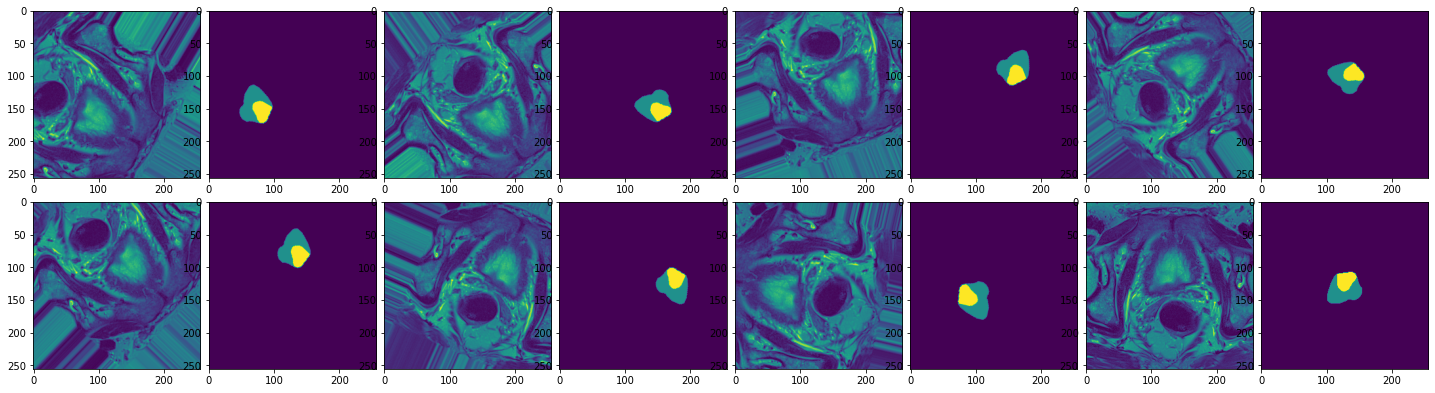

In [19]:
from keras.preprocessing.image import ImageDataGenerator
from random import randint

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 10
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img


data_gen_args = dict(rescale=None,
                     rotation_range=360,
                     width_shift_range=0.2,  
                     height_shift_range=0.2,  
                     zoom_range=0.05,
                     horizontal_flip=True,
                     vertical_flip=True
                     )

image_datagen = ImageDataGenerator( preprocessing_function=add_noise, **data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)


# Select random slice
sample_num = randint(0, 50)
sample = np.load("../input/train_images/sample-" + str(sample_num) + ".npy")
label = np.load("../input/train_labels/sample-" + str(sample_num) + ".npy")

slice_idx = randint(0, len(sample))


seed = 1  # make sure the transformations on both labels and images are the same
image_generator = image_datagen.flow(
    np.expand_dims(sample[slice_idx:slice_idx+1],axis=-1), 
    seed=seed)

mask_generator = mask_datagen.flow(
    np.expand_dims(label[slice_idx:slice_idx+1],axis=-1),
    seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

# Generate distorted images and verify that the mask is moved accordingly!
img = []
labs = []

for batch, lab in train_generator: 
    img.append( batch[0] ) 
    labs.append( lab[0] )
    if len(img) >= 7:
        break

f, xyarr = plt.subplots(2,8, figsize=(25,7))
plt.subplots_adjust(wspace = 0.05, hspace = 0.01)

xyarr[0,0].imshow(img[0][:,:,0])
xyarr[0,1].imshow(labs[0][:,:,0])
xyarr[1,0].imshow(img[1][:,:,0])
xyarr[1,1].imshow(labs[1][:,:,0])

xyarr[0,2].imshow(img[2][:,:,0])
xyarr[0,3].imshow(labs[2][:,:,0])
xyarr[1,2].imshow(img[3][:,:,0])
xyarr[1,3].imshow(labs[3][:,:,0])


xyarr[0,4].imshow(img[4][:,:,0])
xyarr[0,5].imshow(labs[4][:,:,0])
xyarr[1,4].imshow(img[5][:,:,0])
xyarr[1,5].imshow(labs[5][:,:,0])

xyarr[0,6].imshow(img[6][:,:,0])
xyarr[0,7].imshow(labs[6][:,:,0])
xyarr[1,6].imshow(sample[slice_idx])
xyarr[1,7].imshow(label[slice_idx])

plt.show()

### **Main training pipeline**

In [20]:
# full training procedure:
def train(train_dataset_pre, validation_dataset_pre, epochs, batch_size,  buffer_size, model, optimizer,\
          manager, checkpoint, summary_writer, summary_writer_val, loss_function):
    
    loss_metric = tf.keras.metrics.Mean(name='Loss')
    acc_metric = tf.keras.metrics.CategoricalAccuracy(name='Categorical accuracy')
    
    perclass_prec_metrics = [tf.keras.metrics.Precision(class_id=0, name='Per class 0 precision'),
                             tf.keras.metrics.Precision(class_id=1, name='Per class 1 precision'),
                             tf.keras.metrics.Precision(class_id=2, name='Per class 2 precision')]
    
    iou_metric = tf.keras.metrics.MeanIoU(num_classes=3, name='Intersection over Union')
    
    val_loss_metric = tf.keras.metrics.Mean(name='Validation: Loss')
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy(name='Validation: Categorical accuracy')
    
    val_perclass_prec_metrics = [tf.keras.metrics.Precision(class_id=0, name='Validation: Per class 0 precision'),
                                 tf.keras.metrics.Precision(class_id=1, name='Validation: Per class 1 precision'),
                                 tf.keras.metrics.Precision(class_id=2, name='Validation: Per class 2 precision')]
    
    val_iou_metric = tf.keras.metrics.MeanIoU(num_classes=3, name='Validation: Intersection over Union')
    

    checkpoint.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored model from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")

    epochs_so_far = checkpoint.step
    epochs = epochs + epochs_so_far

    for epoch in tf.range(epochs_so_far, epochs):
        
        train_dataset = train_dataset_pre.flat_map(tf_random_rotate_image).shuffle(buffer_size).batch(batch_size)
        validation_dataset = validation_dataset_pre.flat_map(tf_random_rotate_image).shuffle(buffer_size).batch(batch_size)
    
        start = time.time()

        for image_batch, labels in train_dataset:
            with tf.GradientTape() as grad_tape:
                predicted_logits = model(image_batch)
                #loss = combined_loss(labels, predicted_logits)
                loss = loss_function(**{"true_labels": labels, "predicted_labels": predicted_logits})
                gradients = grad_tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                
            compute_metrics(labels, predicted_logits, loss_metric, acc_metric, perclass_prec_metrics, iou_metric, loss_function)
        
        for image_batch, labels in validation_dataset:
            predicted_logits = model(image_batch, training=False)
            compute_metrics(labels, predicted_logits, val_loss_metric, val_acc_metric, \
                            val_perclass_prec_metrics, val_iou_metric, loss_function)
                        
            
        # take 8 random images from validation set
        # compute one batch confusion matrix
        # add .shuffle(buffer_size) to get something slightly different reach run
        for image_batch, labels in validation_dataset.shuffle(4).take(1): 
            output = model(image_batch, training=False)
            
            true_labels_flat = tf.reshape(tf.argmax(labels, axis=-1), shape=(-1, 1))
            predicted_labels_flat = tf.reshape(tf.argmax(output, axis=-1), shape=(-1, 1))
            # confusion matrix per one batch
            cm = sklearn.metrics.confusion_matrix(true_labels_flat, predicted_labels_flat)
            figure = plot_confusion_matrix(cm, class_names=[0, 1, 2])
            cm_image = plot_to_image(figure)
            # pick 8 images
            output_image = output[:8]
            true_image = labels[:8]
            # to one hot encoding from logits
            output_image = tf.argmax(output_image, axis=-1)
            output_image = tf.one_hot(output_image, 3)
            
            image_comparison = plot_to_image(plot_true_vs_output_images(true_image, output_image))

        # Generate summaries   
        with summary_writer.as_default():
            tf.summary.scalar(name='weighted cross-entropy loss', data=loss_metric.result(), step=epoch)
            tf.summary.scalar(name='OP overall precision', data=acc_metric.result(), step=epoch)
            
            PC = (perclass_prec_metrics[0].result() + perclass_prec_metrics[1].result() \
                  + perclass_prec_metrics[2].result())/3.0
            tf.summary.scalar(name='PC per class precision', data=PC, step=epoch)
                              
            tf.summary.scalar(name='IoU intersection over union', data=iou_metric.result(), step=epoch)
        with summary_writer_val.as_default():
            tf.summary.scalar(name='weighted cross-entropy loss', data=val_loss_metric.result(), step=epoch)
            tf.summary.scalar(name='OP overall precision', data=val_acc_metric.result(), step=epoch)
                              
            val_PC = (val_perclass_prec_metrics[0].result() + val_perclass_prec_metrics[1].result() \
                  + val_perclass_prec_metrics[2].result())/3.0                 
            tf.summary.scalar(name='PC per class precision', data=val_PC, step=epoch)
                              
            tf.summary.scalar(name='IoU intersection over union', data=val_iou_metric.result(), step=epoch)
            tf.summary.image(name='true vs predicted image',  data=image_comparison, step=epoch)
            tf.summary.image("val batch confusion matrix", cm_image, step=epoch)

        print("************************")
        print("Epoch {}".format(epoch))  
        print("Validation set metrics")
        print("Loss value:")
        print(val_loss_metric.result().numpy())
        print("Overall precision:")
        print(val_acc_metric.result().numpy())
        print("Per class precision:")
        print(val_PC.numpy())
        print("Intersection over Union:")
        print(val_iou_metric.result().numpy())


        checkpoint.step.assign_add(1)
        manager.save()

        loss_metric.reset_states()
        acc_metric.reset_states()
        perclass_prec_metrics[0].reset_states()
        perclass_prec_metrics[1].reset_states()
        perclass_prec_metrics[2].reset_states()
        iou_metric.reset_states()
        val_loss_metric.reset_states()
        val_acc_metric.reset_states()
        val_perclass_prec_metrics[0].reset_states()
        val_perclass_prec_metrics[1].reset_states()
        val_perclass_prec_metrics[2].reset_states()
        val_iou_metric.reset_states()
        
        print('Time for epoch {} is {} sec'.format(epoch, time.time() - start))



# **Hyperparameter search**


## **Experiment results**

Architecture | Num. Filter  | Num. Parameters | Loss Function | Loss Weights | Learning Rate | Num. Epochs | IoU | Overall Precision |  Per class precision 
--- | --- | --- |  --- | --- |  --- |  --- | ---  |  --- | --- 
**unet_model_depth_4** | 4 | 93'647 | weighted cross entropy | [0.1, 5.0, 1.6]  | 0.0001 | 10 |  0.3193467 | 0.8387275 | 0.32946548
**unet_model_depth_4** | 4 | 93'647 | weighted cross entropy | equal | 0.0001 | 4 |  0.3070927 | 0.921278 | 0.3070927
**unet_model_depth_4** | 8 | 372'891 |weighted cross entropy | [0.1, 5.0, 1.6]  | 0.0005 | 10 | 0.5037314 | 0.8861653 | 0.60807043
**unet_model_depth_4** | 16 | 1'488'179 |weighted cross entropy | [0.1, 5.0, 1.6]  | 0.0005 | 10 |  0.47584033 | 0.8702365 | 0.5703871
--- | --- | --- |  --- | --- |  --- |  --- | ---  |  --- | --- | --- 
**unet_model_depth_2** | 8 | ? |weighted cross entropy | [0.1, 5.0, 1.6]  | 0.0005 | 10 |  ? | ? | ?
**unet_model_depth_2** | 16 | 540'115 |weighted cross entropy | [0.1, 5.0, 1.6]  | 0.0001 | 10 |  0.3827503 | 0.77088386 | 0.5522721
**unet_model_depth_2** | 16 | 540'115 |combined loss| [0.1, 5.0, 1.6]  | 0.0005 | 20 | 0.46576762 | 0.93662465 | 0.50953573
**unet_model_depth_2** | 32 | ? |weighted cross entropy | [0.1, 5.0, 1.6]  | 0.0001 | 20 | 0.38649967 | 0.75253403 | 0.55872166
**unet_model_depth_2** | 32 | ? |combined loss | default | 0.0001 | 20 | 0.47916582 | 0.940476 | 0.56806666
--- | --- | --- |  --- | --- |  --- |  --- | ---  |  --- | --- | ---
**unet_model_depth_6** | 4 | ? |weighted cross entropy | [0.1, 5.0, 1.6]  | 0.0001 | 10 | ? | ? | ?
**unet_model_depth_6** | 8 | 1'602'843 |weighted cross entropy | [0.1, 5.0, 1.6]  | 0.0001 | 10 | 0.48476997 | 0.8923699 | 0.48476997
**unet_model_depth_6** | 8 | 1'602'843 |focal loss | [0.1, 5.0, 1.6]  | 0.0001 | 5 | 0.3071075 | 0.92131317 | 0.33213827
--- | --- | --- |  --- | --- |  --- |  --- | ---  |  --- | --- | ---
**unet_classic_depth_5** | 4 | 89,215 |weighted cross entropy| [0.1, 5.0, 1.6]  | 0.0001 | 7 | 0.3270237 | 0.8438846 | 0.3286973
**unet_classic_depth_5** | 8 | 355'835 |weighted cross entropy| [0.1, 5.0, 1.6]  | 0.0001 | 10 | 0.43126234 | 0.83297604 | 0.43126234
**unet_classic_depth_5** | 16 | 1'421'299 |weighted cross entropy| [0.1, 5.0, 1.6]  | 0.0001 | 10 | 0.51563 | 0.90100133| 0.57740456
**unet_classic_depth_5** | 32 | 5'681'123 |weighted cross entropy| [0.1, 5.0, 1.6]  | 0.0001 | 29 | 0.38640758 | 0.8679879 | 0.43646288
--- | --- | --- |  --- | --- |  --- |  --- | ---  |  --- | --- | ---
**VGG** | NA | 11'585'411 | combined loss| [0.1, 5.0, 1.6]  | 0.0001 | 29 | 0.53211695 | 0.9464095 | 0.7006528
**VGG** | NA | 11'585'411 |weighted cross entropy| default | 0.0001 | 20 | 0.39208874 | 0.81938297 | 0.0.6652792
--- | --- | --- |  --- | --- |  --- |  --- | ---  |  --- | --- | ---
**FCN 8** | NA | 134,276,585 |weighted cross entropy | default | 0.0001 | 19 |  0.22546817 | 0.4813198 | 0.40842617




In [26]:
class Arguments:
    # model naming
    version = None # model version

    # hyper parameters
    epochs = 30 # number of epochs to train the model
    batch_size = 16 # nr of images per batch

    # model settings
    buffer_size = 256 # buffer size for shuffling
    img_width = 256 # image width
    img_height = 256 # image height

    # paths
    train_image_path = '../input/train_images/'
    train_label_path ='../input/train_labels/'
    # TODO add for testing
    # test_image_path = 
    # test_label_path = 
    checkpoint_dir = 'checkpoints/'

    
args = Arguments()
args.version = 'v301'#'v109'
args.logs_dir = './logs/'

In [22]:
train_dataset_pre, validation_dataset_pre = load_data(args.train_image_path, args.train_label_path)

**** Generate training dataset ****
# images
758
Image size
(256, 256, 1)
# labels
758
Label size
(256, 256, 3)
Class statistics:
Class 0: 93.77%
Class 1: 2.06%
Class 2: 4.17%
758
**** Generate validation dataset ****
# images
84
Image size
(256, 256, 1)
# labels
84
Label size
(256, 256, 3)
Class statistics:
Class 0: 92.14%
Class 1: 1.89%
Class 2: 5.97%


In [27]:
# -------------------------------------- < main hyperparameters >
conv_nodes_1 = 16
learning_rate = 1e-3                    # 1.5e-4  0.0001 # 1e-3
args.epochs = 20

weights_training = [0.1, 5.0, 3.4]   
                                        # [0.1, 5.0, 1.6] 
                                        # [0.1, 5.0, 3.4]  
                                        # [0.5, 5.0, 2.4]    
                                        # ...
        
combined_loss_local = combined_loss(weights = [0.3, 0.7])  
loss_function_training = weigthed_cross_entropy(weights_per_class = weights_training)

                                        # combined_loss(weights = [0.1, 0.9])
                                        # weigthed_cross_entropy(weights_per_class = weights_training)
                                        # focal_loss_local 
                                        # ...



# SELECT NN ARCHITECTURE! 
unet_model = get_unet_classic_depth_5(input_dims=(256, 256, 1), **{"conv_nodes_1": conv_nodes_1} )
                                        # fcn8()
                                        # VGGSegnet()
                                        # make_unet_model_depth_2(input_dims=(256, 256, 1), **{"conv_nodes_1": conv_nodes_1})
                                        # get_unet_classic_depth_5(input_dims=(256, 256, 1), **{"conv_nodes_1": conv_nodes_1} )
unet_model.summary()

# -------------------------------------- </ main hyperparameters >

# Define the location of the checkpoint: allows to monitor different models

if loss_function_training.name == 'weigthed_cross_entropy':
    loss_function_training.name = "{}_{}_{}_{}".format(loss_function_training.name, 
                                                       weights_training[0], weights_training[1], weights_training[2])

args.checkpoint_dir = "{}_{}_{}".format( unet_model.model_name, loss_function_training.name, conv_nodes_1 )

# set up summary writers
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = args.logs_dir + args.version + "/" + args.checkpoint_dir 
summary_writer = tf.summary.create_file_writer(log_dir + "/training")
summary_writer_val = tf.summary.create_file_writer(log_dir + "/validation")

#----------------------------------------------------------------
# optimizers
unet_optimizer = tf.keras.optimizers.Adam( learning_rate )

# define checkpoint
checkpoint_dir = os.path.join(args.checkpoint_dir, args.version)
checkpoint = tf.train.Checkpoint(step=tf.Variable(0, dtype=tf.int64),
                                 unet_optimizer=unet_optimizer,
                                 unet_model=unet_model)

manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=100)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 256, 256, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_46[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_47[0][0]                  
____________________________________________________________________________________________

In [ ]:
%tensorboard --logdir { log_dir }

All the experiments were ran on **Google colab**, since there were issues with using tensorflow with GPU on a macbook from 2014. 

In [28]:
train(train_dataset_pre, validation_dataset_pre, 
      epochs=args.epochs, batch_size=args.batch_size,buffer_size=args.buffer_size,
      model=unet_model,  optimizer=unet_optimizer,
      manager=manager, checkpoint=checkpoint, summary_writer=summary_writer, summary_writer_val=summary_writer_val,
      loss_function = loss_function_training  
      )

Initializing from scratch.


KeyboardInterrupt: 

## Conclusions

1.  Selecting weights for weighted cross entropy is a delicate process, since there is a high risk that the predictions will degenerate into single class after several epochs. 
    
2. Combined loss tends to yield better results than weighted cross entropy
    
3. The optimal number of filters in the first convolution layer for U-net seems to be betweeen 8 and 16. The shallowest model with depth 2 performed markedly worse than other models considered
    
4. FCN8 has too many parameters, would have needed much more epochs to produce reasonable results, by which time the checkpoints will probably occupy the entire RAM.  We have tried it out as a proof of concept, however for the above mentioned reasons we did not explore it further.
    
5. VGG net seemed to be promising, but the training progress was not very stable.
    
6. **Changing the loss function had a stronger effect on the model performance then variations in architecture.**

